In [1]:
# load dataset
import _pickle as cPickle
from pathlib import Path

data_path = Path('/home/yoojin/data/emotionDataset/final/save')

with open(data_path.joinpath('raw_feature_dataset_dict.dat'), 'rb') as f:
    u = cPickle.Unpickler(f)
    total_dataset = u.load()

In [3]:
# split train and test
train_data = []
test_data = []

for feature_data in total_dataset:
    set_name = feature_data['set_name']
    if set_name in TEST_LIST:
        test_data.append(feature_data)
    else:
        train_data.append(feature_data)

total_data = train_data + test_data


In [99]:
import numpy as np

feature_keys = FEATURE_KEYS

def make_X_Y(total_dataset, feature_keys):
    x = []
    y = []

    for dataset in total_dataset:
        emotion_number = dataset['emotion_number']

        data = []
        for key in feature_keys:
            data.append(dataset['scaled_statistics'][key])
        x.append(data)
        y.append(emotion_number)

    return np.array(x), np.array(y)

total_X, total_Y = make_X_Y(total_data, feature_keys)
train_X, train_Y = make_X_Y(train_data, feature_keys)
test_X, test_Y = make_X_Y(test_data, feature_keys)

### Bagging Ensemble: Random Forest Classifier

In [100]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf.fit(train_X, train_Y)
pred = rf.predict(test_X)

In [35]:
import pandas as pd

print("total_accuracy : %0.3f" % rf.score(test_X, test_Y))
total_result = get_total_result(pred, test_Y)
print_total_result(total_result)

total_accuracy : 0.884
single_to_single
     0         1         2         3         4
0  1.0  0.000000  0.000000  0.000000  0.000000
1  0.0  0.870968  0.064516  0.064516  0.000000
2  0.0  0.096774  0.870968  0.000000  0.032258
3  0.0  0.064516  0.032258  0.806452  0.096774
4  0.0  0.064516  0.032258  0.032258  0.870968
single_to_arousal
          0         1
0  0.064516  0.935484
1  0.032258  0.967742
2  0.903226  0.096774
3  0.903226  0.096774
single_to_valence
          0         1
0  0.935484  0.064516
1  0.096774  0.903226
2  0.870968  0.129032
3  0.096774  0.903226
arousal_to_arousal
          0         1
0  0.903226  0.096774
1  0.048387  0.951613
valence_to_valence
          0         1
0  0.903226  0.096774
1  0.096774  0.903226


In [86]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6,8,10,12],
    'min_samples_leaf': [3,5, 7, 10],
    'min_samples_split': [2,3,5,10]
}

In [87]:
from sklearn.model_selection import GridSearchCV

rf_grid = GridSearchCV(rf, param_grid=rf_param_grid, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(train_X, train_Y)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   42.3s finished


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [3, 5, 7, 10],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [39]:
print(rf_grid.best_params_)
# overfitting: result 85.2%

{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


### Boosting Ensemble: Gradient Boosting (similar as AdaBoost) Machine

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(train_X, train_Y)
pred = gb.predict(test_X)

In [46]:
print("total_accuracy : %0.3f" % rf.score(test_X, test_Y))
total_result = get_total_result(pred, test_Y)
print_total_result(total_result)

total_accuracy : 0.852
single_to_single
     0         1         2         3         4
0  1.0  0.000000  0.000000  0.000000  0.000000
1  0.0  0.870968  0.064516  0.064516  0.000000
2  0.0  0.161290  0.806452  0.000000  0.032258
3  0.0  0.032258  0.032258  0.838710  0.096774
4  0.0  0.129032  0.064516  0.064516  0.741935
single_to_arousal
          0         1
0  0.064516  0.935484
1  0.032258  0.967742
2  0.935484  0.064516
3  0.806452  0.193548
single_to_valence
          0         1
0  0.935484  0.064516
1  0.161290  0.838710
2  0.870968  0.129032
3  0.193548  0.806452
arousal_to_arousal
          0         1
0  0.870968  0.129032
1  0.048387  0.951613
valence_to_valence
          0         1
0  0.903226  0.096774
1  0.177419  0.822581


In [49]:
gb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6,8,10,12],
    'min_samples_leaf': [3,5, 7, 10],
    'min_samples_split': [2,3,5,10],
    'learning_rate':[0.01, 0.001, 0.1, 0.2, 0.05]
}

In [50]:
gb_grid = GridSearchCV(gb, param_grid=gb_param_grid, scoring='accuracy', n_jobs=-1, verbose=1)
gb_grid.fit(train_X, train_Y)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed: 40.2min finished


GridSearchCV(estimator=GradientBoostingClassifier(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.001, 0.1, 0.2, 0.05],
                         'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [3, 5, 7, 10],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [51]:
gb_grid.best_params_

{'learning_rate': 0.2,
 'max_depth': 12,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 200}

In [55]:
model = gb_grid.best_estimator_
pred = model.predict(test_X)

print("total_accuracy : %0.3f" % model.score(test_X, test_Y))
total_result = get_total_result(pred, test_Y)
print_total_result(total_result)

total_accuracy : 0.884
single_to_single
     0         1         2         3         4
0  1.0  0.000000  0.000000  0.000000  0.000000
1  0.0  0.838710  0.064516  0.096774  0.000000
2  0.0  0.129032  0.838710  0.000000  0.032258
3  0.0  0.032258  0.032258  0.870968  0.064516
4  0.0  0.032258  0.064516  0.032258  0.870968
single_to_arousal
          0         1
0  0.096774  0.903226
1  0.032258  0.967742
2  0.935484  0.064516
3  0.903226  0.096774
single_to_valence
          0         1
0  0.935484  0.064516
1  0.129032  0.870968
2  0.903226  0.096774
3  0.064516  0.935484
arousal_to_arousal
          0         1
0  0.919355  0.080645
1  0.064516  0.935484
valence_to_valence
          0         1
0  0.919355  0.080645
1  0.096774  0.903226


In [57]:
model.feature_importances_

array([0.09326218, 0.11319561, 0.07283457, 0.0718662 , 0.12847881,
       0.07729616, 0.13350904, 0.09354299, 0.11200049, 0.10401396])

### Boosting Ensemble: XGBoost Machine

In [59]:
from xgboost import plot_importance, XGBClassifier

In [63]:
xgb = XGBClassifier(random_state=0)
xgb.fit(train_X, train_Y)
pred = xgb.predict(test_X)

print("total_accuracy : %0.3f" % xgb.score(test_X, test_Y))
total_result = get_total_result(pred, test_Y)
print_total_result(total_result)

total_accuracy : 0.839
single_to_single
     0         1         2         3         4
0  1.0  0.000000  0.000000  0.000000  0.000000
1  0.0  0.806452  0.064516  0.129032  0.000000
2  0.0  0.129032  0.838710  0.000000  0.032258
3  0.0  0.032258  0.032258  0.774194  0.161290
4  0.0  0.096774  0.096774  0.032258  0.774194
single_to_arousal
          0         1
0  0.129032  0.870968
1  0.032258  0.967742
2  0.935484  0.064516
3  0.806452  0.193548
single_to_valence
          0         1
0  0.935484  0.064516
1  0.129032  0.870968
2  0.806452  0.193548
3  0.129032  0.870968
arousal_to_arousal
          0         1
0  0.870968  0.129032
1  0.080645  0.919355
valence_to_valence
          0         1
0  0.870968  0.129032
1  0.129032  0.870968


In [64]:
xgb_param_grid = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [4, 6,8,10,12],
    'learning_rate':[0.01, 0.15, 0.1, 0.2, 0.05]
}

In [65]:
xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='accuracy', n_jobs=-1, verbose=1)
xgb_grid.fit(train_X, train_Y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished


GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                                     tree

In [67]:
model = xgb_grid.best_estimator_
pred = model.predict(test_X)

print("total_accuracy : %0.3f" % model.score(test_X, test_Y))
total_result = get_total_result(pred, test_Y)
print_total_result(total_result)

total_accuracy : 0.858
single_to_single
     0         1         2         3         4
0  1.0  0.000000  0.000000  0.000000  0.000000
1  0.0  0.870968  0.064516  0.064516  0.000000
2  0.0  0.129032  0.838710  0.000000  0.032258
3  0.0  0.032258  0.032258  0.838710  0.096774
4  0.0  0.096774  0.096774  0.064516  0.741935
single_to_arousal
          0         1
0  0.064516  0.935484
1  0.032258  0.967742
2  0.935484  0.064516
3  0.806452  0.193548
single_to_valence
          0         1
0  0.935484  0.064516
1  0.129032  0.870968
2  0.870968  0.129032
3  0.161290  0.838710
arousal_to_arousal
          0         1
0  0.870968  0.129032
1  0.048387  0.951613
valence_to_valence
          0         1
0  0.903226  0.096774
1  0.145161  0.854839


### Boosting Ensemble: LightGBM

In [72]:
from lightgbm import LGBMClassifier, plot_importance

lgb = LGBMClassifier(random_state=0)
lgb.fit(train_X, train_Y)
pred = lgb.predict(test_X)

print("total_accuracy : %0.3f" % lgb.score(test_X, test_Y))
total_result = get_total_result(pred, test_Y)
print_total_result(total_result)

total_accuracy : 0.865
single_to_single
     0         1         2         3         4
0  1.0  0.000000  0.000000  0.000000  0.000000
1  0.0  0.870968  0.064516  0.064516  0.000000
2  0.0  0.096774  0.870968  0.000000  0.032258
3  0.0  0.032258  0.032258  0.806452  0.129032
4  0.0  0.000000  0.096774  0.129032  0.774194
single_to_arousal
          0         1
0  0.064516  0.935484
1  0.032258  0.967742
2  0.935484  0.064516
3  0.903226  0.096774
single_to_valence
          0         1
0  0.935484  0.064516
1  0.096774  0.903226
2  0.838710  0.161290
3  0.129032  0.870968
arousal_to_arousal
          0         1
0  0.919355  0.080645
1  0.048387  0.951613
valence_to_valence
          0         1
0  0.887097  0.112903
1  0.112903  0.887097


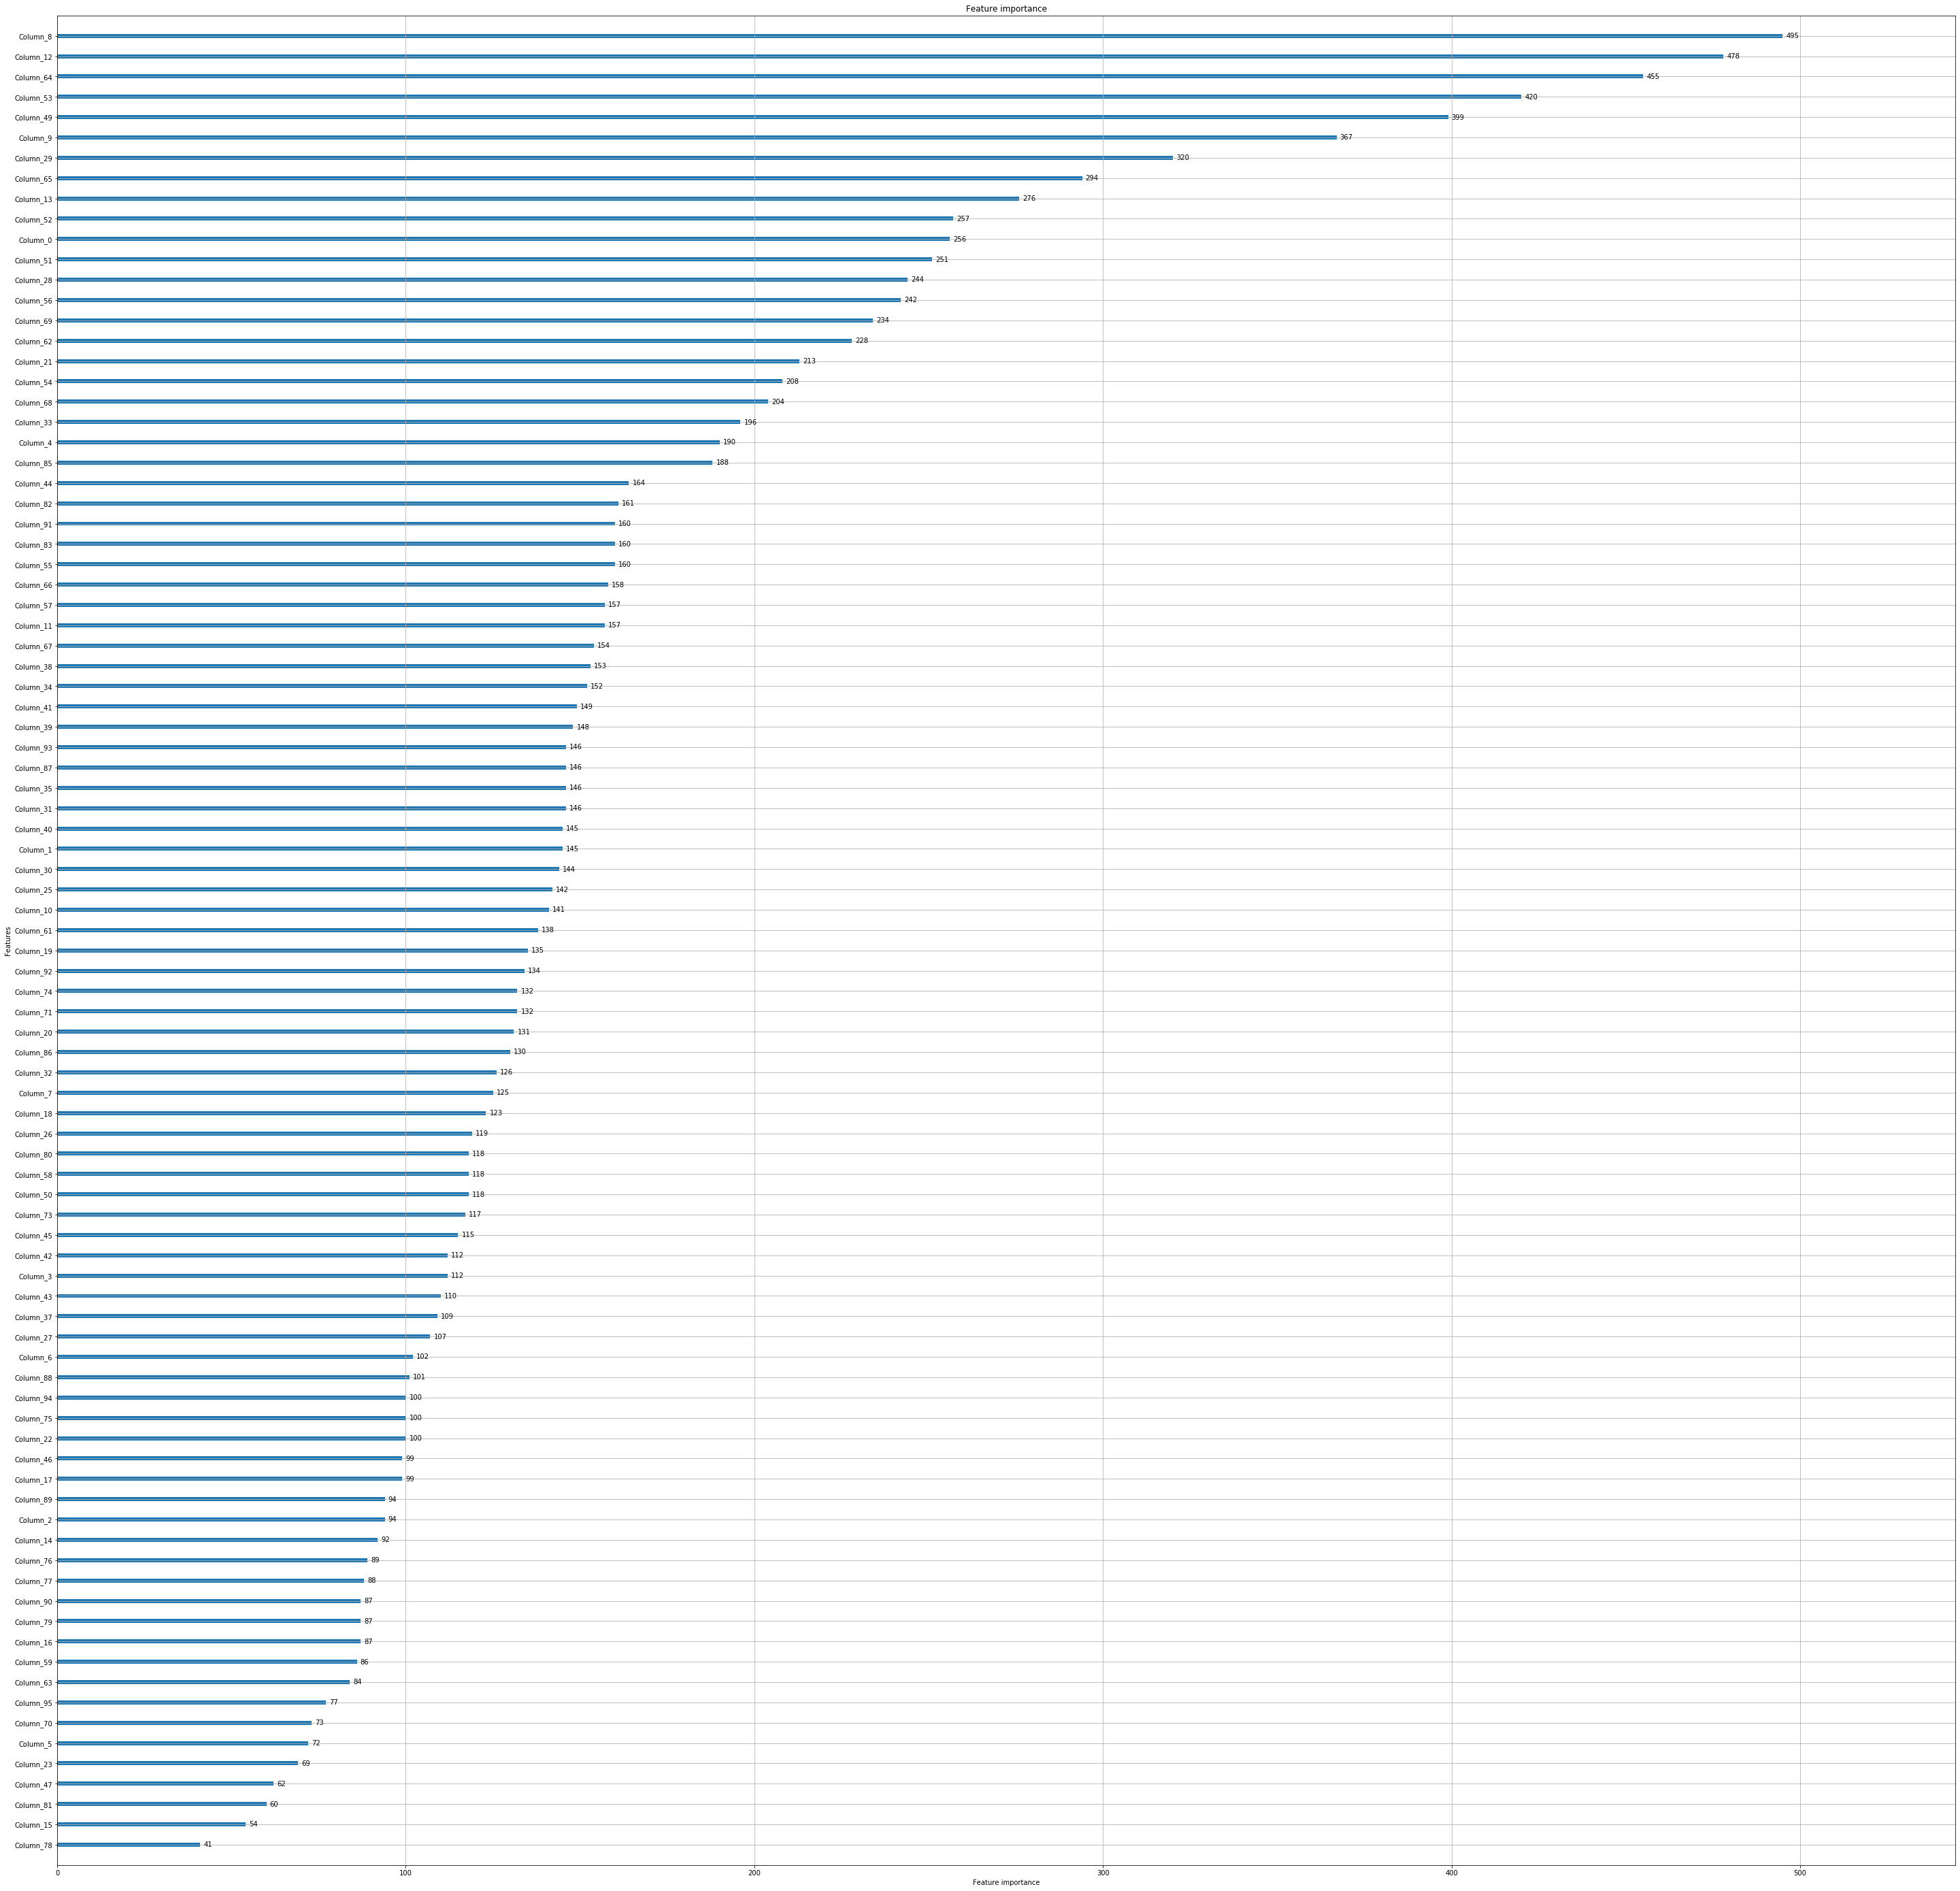

In [77]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(50,50))
plot_importance(lgb, ax=ax)


In [79]:
TOTAL_FEATURE_KEYS = list(total_dataset[0]['scaled_statistics'].keys())

In [80]:
index_list = [8, 12, 64, 53, 49, 9, 29, 65, 13, 52, 0, 51, 28, 56, 69, 62, 21, 54, 68]
key_list= []
for index in index_list:
    key_list.append(TOTAL_FEATURE_KEYS[index])

In [82]:
relatives = []
ori = []
for key in key_list:
    if '_ratio_' in key or 'relative_' in key:
        relatives.append(key)
    else:
        ori.append(key)
        
print(relatives)
print(ori)

['original_duration_ratio_mean', 'velocity_ratio_std', 'relative_velocity_std', 'beat_tempo_ratio_std', 'original_duration_ratio_std', 'velocity_ratio_mean', 'relative_velocity_kurt', 'beat_tempo_ratio_mean', 'relative_original_duration_skew', 'velocity_ratio_skew']
['velocity_mean', 'original_duration_mean', 'velocity_std', 'original_duration_std', 'beat_tempo_mean', 'velocity_diff_mean', 'original_duration_diff_std', 'onset_deviation_std', 'original_duration_diff_mean']


In [95]:
TEST_FEATURE_KEYS = ['beat_tempo_ratio_mean',
                'beat_tempo_ratio_std',
                'relative_beat_tempo_mean',

                'velocity_ratio_mean',
                'velocity_ratio_std',
                'relative_velocity_mean',
                'relative_velocity_std',
                'relative_velocity_kurt',
                'velocity_ratio_skew',

                'original_duration_ratio_mean',
                'original_duration_ratio_std', 
                'relative_original_duration_skew']

In [8]:
FEATURE_KEYS = ['beat_tempo_ratio_mean',
                'beat_tempo_ratio_std',
                'relative_beat_tempo_mean',

                'velocity_ratio_mean',
                'velocity_ratio_std',
                'relative_velocity_mean',
                'relative_velocity_std',
                'relative_velocity_kurt',

                'original_duration_ratio_mean',
                'relative_original_duration_mean']

In [14]:
def get_total_result(predicted, answer):
    result = get_result_num(predicted, answer)

    total_result = dict()
    # 1. Single emotion -> Single emotion accuracy
    ratio_result = get_ratio_result(result)
    total_result['single_to_single'] = ratio_result

    # 2. Single emotion -> Arousal accuracy
    e2_to_HA = ratio_result[1][3] + ratio_result[1][4]
    e2_to_LA = ratio_result[1][1] + ratio_result[1][2]
    e3_to_HA = ratio_result[2][3] + ratio_result[2][4]
    e3_to_LA = ratio_result[2][2] + ratio_result[2][1]
    e4_to_HA = ratio_result[3][3] + ratio_result[3][4]
    e4_to_LA = ratio_result[3][1] + ratio_result[3][2]
    e5_to_HA = ratio_result[4][4] + ratio_result[4][3]
    e5_to_LA = ratio_result[4][1] + ratio_result[4][2]
    total_result['single_to_arousal'] = [[e2_to_HA, e2_to_LA],
                                        [e3_to_HA, e3_to_LA],
                                        [e4_to_HA, e4_to_LA],
                                        [e5_to_HA, e5_to_LA]]

    # 3. Single emotion -> Valence accuracy
    e2_to_PV = ratio_result[1][1] + ratio_result[1][3]
    e2_to_NV = ratio_result[1][2] + ratio_result[1][4]
    e3_to_PV = ratio_result[2][1] + ratio_result[2][3]
    e3_to_NV = ratio_result[2][2] + ratio_result[2][4]
    e4_to_PV = ratio_result[3][3] + ratio_result[3][1]
    e4_to_NV = ratio_result[3][2] + ratio_result[3][4]
    e5_to_PV = ratio_result[4][1] + ratio_result[4][3]
    e5_to_NV = ratio_result[4][4] + ratio_result[4][2]
    total_result['single_to_valence'] = [[e2_to_PV, e2_to_NV],
                                        [e3_to_PV, e3_to_NV],
                                        [e4_to_PV, e4_to_NV],
                                        [e5_to_PV, e5_to_NV]]

    # 4. Arousal -> Arousal accuracy
    HA_to_HA = (result[3][3]+result[3][4]+result[4][3] +
                result[4][4]) / (sum(result[3]) + sum(result[4]))
    HA_to_LA = (result[3][1]+result[3][2]+result[4][1] +
                result[4][2]) / (sum(result[3]) + sum(result[4]))
    LA_to_LA = (result[1][1]+result[1][2]+result[2][1] +
                result[2][2]) / (sum(result[1])+sum(result[2]))
    LA_to_HA = (result[1][3]+result[1][4]+result[2][3] +
                result[2][4]) / (sum(result[1])+sum(result[2]))
    total_result['arousal_to_arousal'] = [[HA_to_HA, HA_to_LA],
                                        [LA_to_HA, LA_to_LA]]

    # 5. Valence -> Valence accuracy
    PV_to_PV = (result[1][1]+result[1][3]+result[3][1] +
                result[3][3]) / (sum(result[1]) + sum(result[3]))
    PV_to_NV = (result[1][2]+result[1][4]+result[3][2] +
                result[3][4]) / (sum(result[1]) + sum(result[3]))
    NV_to_NV = (result[2][2]+result[2][4]+result[4][2] +
                result[4][4]) / (sum(result[2]) + sum(result[4]))
    NV_to_PV = (result[2][1]+result[2][3]+result[4][1] +
                result[4][3]) / (sum(result[2]) + sum(result[4]))
    total_result['valence_to_valence'] = [[PV_to_PV, PV_to_NV],
                                        [NV_to_PV, NV_to_NV]]

    return total_result

def get_result_num(predicted, answer):
    result = [[0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0]]
    for pred, ans in zip(predicted, answer):
        result[ans-1][pred-1] += 1
    return result

def get_ratio_result(result):
    ratio_result = [[0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0]]
    for i, emotion in enumerate(result):
        for j, pred_num in enumerate(emotion):
            ratio_result[i][j] = pred_num/sum(emotion)

    return ratio_result

def print_total_result(total_result):
    for key in total_result.keys():
        print(key)
        df = pd.DataFrame(total_result[key])
        print(df)

In [2]:
TEST_LIST = ['Bach.french-suite_bwv812_no1_allemande.mm_1-end.s004',
             'Bach.french-suite_bwv816_no5_courante.mm_1-end.s002',
             'Chopin.nocturne_op9_no2_.mm_1-12.s021',
             'Schumann.fantasiestucke_op12_no3_.mm_1-42.s021',
             'Bach.minuet_bwv114__.mm_1-32.s018',
             'Schubert.impromptu_op142_no3_var1.mm_1-end.s018',
             'Schubert.impromptu_op142_no3_thema.mm_1-end.s018',
             'Schumann.symphonicetudes_op.13_thema.mm_1-end.s018',
             'Chopin.waltz_op69_no1_.mm_1-16.s020',
             'Bach.minuet_bwv114__.mm_1-32.s016',
             'Schumann.kinderszenen_op15_no7_traumerei.mm_1-end.s014',
             'Schumann.davidsbundlertanze_op6_no2_.mm_1-end.s015',
             'Bartok.roumanian-folk-dances_sz56_no3_.mm_1-end.s005',
             'Bartok.roumanian-folk-dances_sz56_no4_.mm_1-end.s005',
             'Bach.prelude-and-fugue_bwv875_no6_prelude.mm_1-end.s022',
             'Rachmaninoff.piano-concerto_op18_no2_mov1.mm_83-103.s022',
             'Chopin.prelude_op28_no4_.mm_1-12.s007',
             'Beethoven.sonata_op31-2_no17_mov2.mm_1-17.s007',
             'Chopin.valse-brillante_op34_no2_.mm_1-36.s007',
             'Chopin.nocturne_op9_no2_.mm_1-12.s007',
             'Liszt.consolation_s172_no3_.mm_1-45.s007',
             'Mozart.sonata_k545_no16_mov3.mm_1-20.s007',
             'Mozart.sonata_k332_no12_mov2.mm_1-8.s007',
             'Beethoven.sonata_op57_no23_mov3.mm_1-67.s007',
             'Chopin.etude_op25_no7_.mm_1-20.s007',
             'Schumann.kinderszenen_op15_no7_traumerei.mm_1-end.s007',
             'Bach.prelude-and-fugue_bwv880_no11_prelude.mm_1-end.s006',
             'Rachmaninoff.sonata_op36_no2_mov1.mm_1-37.s011',
             'Clementi.sonatine_op36_no1_mov2.mm_1-end.s012',
             'Chopin.valse-brillante_op34_no2_.mm_1-36.s008',
             'Chopin.etude_op10_no4_.mm_1-33.s013']